In [ ]:
!pip install transformers datasets evaluate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.6 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
import evaluate
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import shutil

In [ ]:
!pip install --upgrade transformers datasets fsspec huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
cache_dir = os.path.expanduser("~/.cache/huggingface/datasets/wangrongsheng___ag_news")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)

# Now re-load the dataset
dataset = load_dataset("wangrongsheng/ag_news")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# 2. Tokenizer and preprocessing
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.remove_columns(["text"])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")

train_ds = tokenized["train"].shuffle(seed=42).select(range(10000))
test_ds = tokenized["test"].select(range(2000))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
#  Load pre-trained BERT model for 4-class classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)


accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    output_dir="./bert-ag-news",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-5-2126728245.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.339200,0.303625,0.912000,0.912742,0.912000,0.911941
2,0.233700,0.316083,0.920500,0.920318,0.920500,0.920384
3,0.134600,0.385209,0.923500,0.923878,0.923500,0.923347
4,0.071000,0.396946,0.927000,0.927075,0.927000,0.926800
5,0.032300,0.442230,0.925000,0.925076,0.925000,0.924898


TrainOutput(global_step=6250, training_loss=0.17776953872680665, metrics={'train_runtime': 1417.503, 'train_samples_per_second': 35.273, 'train_steps_per_second': 4.409, 'total_flos': 3288947251200000.0, 'train_loss': 0.17776953872680665, 'epoch': 5.0})

In [ ]:
model.save_pretrained("./bert-ag-news-model")
tokenizer.save_pretrained("./bert-ag-news-model")

('./bert-ag-news-model/tokenizer_config.json',
 './bert-ag-news-model/special_tokens_map.json',
 './bert-ag-news-model/vocab.txt',
 './bert-ag-news-model/added_tokens.json',
 './bert-ag-news-model/tokenizer.json')

In [ ]:
# Load the tokenizer and model from the saved directory
model_path = "./bert-ag-news-model"

tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

In [ ]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.44222986698150635, 'eval_accuracy': 0.925, 'eval_precision': 0.9250758430815508, 'eval_recall': 0.925, 'eval_f1': 0.9248978390780249, 'eval_runtime': 14.2248, 'eval_samples_per_second': 140.6, 'eval_steps_per_second': 17.575, 'epoch': 5.0}


In [ ]:
labels = dataset["train"].features["label"].names
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    # Move inputs to the same device as the model
    device = model.device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = labels[torch.argmax(logits, dim=-1)]
    return pred

# Example predictions
print(predict("NASA launches new rocket to explore Mars."))
print(predict("The stock market saw significant drops today."))

Sci/Tech
Business


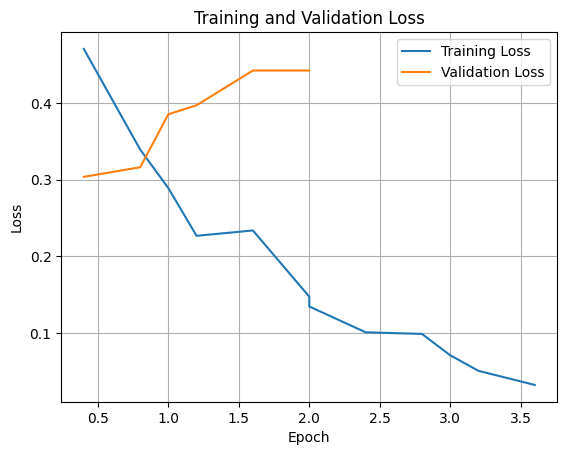

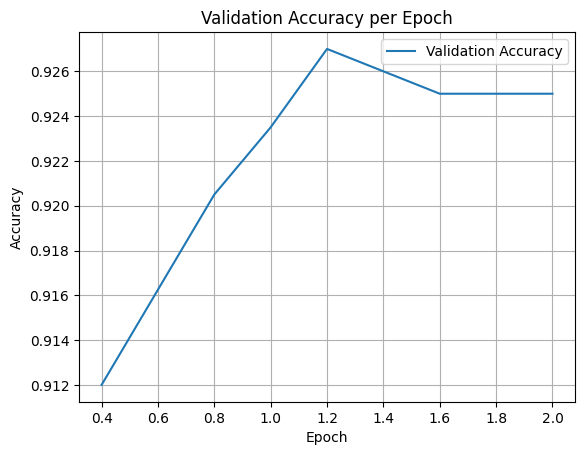

In [ ]:
# Access logs
history = trainer.state.log_history

# Extract values
epochs = []
train_loss = []
eval_loss = []
eval_acc = []

for log in history:
    if 'epoch' in log:
        epochs.append(log['epoch'])
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            eval_loss.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            eval_acc.append(log['eval_accuracy'])

# Plot Loss
plt.figure()
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(epochs[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
if eval_acc:
    plt.figure()
    plt.plot(epochs[:len(eval_acc)], eval_acc, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()
